# 1. Importing libraries, helper functions and data paths

### 1. Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchinfo import summary

In [2]:
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [3]:
from typing import List, Tuple, Dict
from tqdm.auto import tqdm 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
os.makedirs(name = 'Publication_Phase_2_logs', exist_ok=True)

In [6]:
os.makedirs(name = 'Publication_Phase_2_models', exist_ok=True)

### 1.2 Importing helper functions

In [7]:
from going_modular.engine import train_step
from going_modular.data_setup import create_dataloaders

In [8]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device = torch.device)->Tuple[float,float]:

    #putting model on evaluation mode
    model.eval()

    #Setup test loss and test accuracy values
    val_loss, val_acc = 0,0

    #turning on inference mode (we don't need the gradient engine activated)
    with torch.inference_mode():
        #Loop through Dataloader batches
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)

            #1. Forward pass
            val_pred_logits = model(X)

            #2. Calculate the loss
            loss = loss_fn(val_pred_logits,y)
            val_loss += loss.item()

            #Calculate the accuracy
            val_pred_labels = torch.argmax(val_pred_logits, axis = 1)
            val_acc += (val_pred_labels==y).sum().item()/len(val_pred_labels)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)

    return val_loss, val_acc

In [9]:
from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str,
                 model_name: str,
                 extra: str = None):
    '''
    Creates a torch.utils.tensorboard.writer.SummaryWriter() instance trancking to a specific directory
    '''
    from datetime import datetime
    import os

    #get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name,extra)
    else:
        log_dir = os.path.join('Publication_Phase_2_logs',timestamp,experiment_name,model_name)

    print(f"Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir)

In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(model: torch.nn.Module,
         train_dataloader,
         val_dataloader,
         optimizer,
         writer: torch.utils.tensorboard.writer.SummaryWriter,
         loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
         epochs: int = 5,
         device = torch.device,
         lr_scheduler = None)->Dict[str,List]:

    #Create dictionary of lists
    results = {"train_loss": [],
              "train_acc": [],
              "val_loss": [],
              "val_acc": []}

    #looping through training and test steps
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        val_loss, val_acc = val_step(model = model,
                                       dataloader = val_dataloader,
                                       loss_fn = loss_fn,
                                       device = device)
        current_lr = optimizer.param_groups[0]['lr']

        #print out what's happening
        print(f'''Epoch: {epoch+1}| Train loss: {train_loss:.4f} and Train acuuracry: {train_acc:.4f} |
                  Validation loss: {val_loss:.4f} and Validation accuracy: {val_acc:.4f}|
                  LR: {current_lr}''')


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        ###Alteration (NEW): Experiment Tracking###
        if writer:
            writer.add_scalars(main_tag = "Loss",
                              tag_scalar_dict = {"train_loss":train_loss,
                                                "val_loss":val_loss},
                              global_step=epoch)
            writer.add_scalars(main_tag = "Accuracy",
                             tag_scalar_dict = {"train_acc":train_acc,
                                               "val_acc":val_acc},
                             global_step = epoch)
            if epoch == 0:
                writer.add_graph(model = model,
                                input_to_model = torch.randn(32,3,224,224).to(device))
        else:
            pass

        #stepping the lr_scheduler
        if lr_scheduler is not None:
            lr_scheduler.step()
    #Close the writer
    writer.close()

    return results

In [11]:
def save_model(model: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
               epoch: int = 0,
               initial_training_completed: bool = False,
               target_dir: str = "models",
               model_name: str = "model_checkpoint.pth"):
    """
    Saves a dictionary containing model, optimizer, scheduler states, and training metadata.

    Args:
        model: The PyTorch model to save.
        optimizer: The optimizer used during training.
        scheduler: The learning rate scheduler used during training (optional).
        epoch: The current epoch number.
        initial_training_completed: Flag indicating if initial training phase is complete.
        target_dir: Directory where the checkpoint will be saved.
        model_name: Filename for the checkpoint, should end with '.pth' or '.pt'.

    Example usage:
        save_model(model=model_0,
                   optimizer=optimizer,
                   scheduler=scheduler,
                   epoch=15,
                   initial_training_completed=True,
                   target_dir="models",
                   model_name="efficientnet_b0_initial_training.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), \
        "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'initial_training_completed': initial_training_completed,
    }

    print(f"[INFO] Saving checkpoint to: {model_save_path}")
    torch.save(obj=checkpoint, f=model_save_path)

In [12]:
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]], title=None):
    '''
    Plots training curves of a results dictionary with unique markers and grid lines.
    '''
    # Get the loss and accuracy values
    loss = results["train_loss"]
    test_loss = results["val_loss"]
    accuracy = results["train_acc"]
    test_accuracy = results["val_acc"] 
    
    # Number of epochs
    epochs = range(len(loss))
    
    # Setup plot
    plt.figure(figsize=(15, 7))
    
    # Plot the loss with unique markers
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss', marker='o', linestyle='-')
    plt.plot(epochs, test_loss, label='Val Loss', marker='D', linestyle='--')
    plt.title('Loss' if title is None else f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    # Plot the accuracy with unique markers
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="Train Accuracy", marker='*', linestyle='-')
    plt.plot(epochs, test_accuracy, label="Val Accuracy", marker='^', linestyle='--')
    plt.title("Accuracy" if title is None else f'{title} - Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List
import numpy as np

def plot_confusion_matrix(model: torch.nn.Module,
                          dataloader: torch.utils.data.DataLoader,
                          class_names: List[str],
                          device=torch.device("cpu")):
    """
    Computes and plots the confusion matrix for a given model and dataloader.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test dataset.
        class_names: List of class names in the same order as in ImageFolder.
        device: Device on which computation should happen (default: "cpu").
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_multiclass_pr_curve(model, dataloader, class_names, device):

    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    plt.figure()
    for i, class_name in enumerate(class_names):
        # One-vs-rest binarization for true labels
        binary_true = (y_true == i).astype(int)
        precision, recall, _ = precision_recall_curve(binary_true, y_score[:, i])
        plt.plot(recall, precision, label=f'PR Curve: {class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve')
    plt.legend()
    plt.show()

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


def plot_multiclass_roc_curve(model, dataloader, class_names, device):

    model.eval()
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Softmax for multiclass
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    plt.figure()
    for i, class_name in enumerate(class_names):
        binary_true = (y_true == i).astype(int)
        fpr, tpr, _ = roc_curve(binary_true, y_score[:, i])
        plt.plot(fpr, tpr, label=f'ROC Curve: {class_name}')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend()
    plt.show()

### 1.3 Importing data paths

* **Original Data**

In [16]:
root_dir = Path('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split')

train_dir = root_dir/'Train'
val_dir = root_dir/"Validation"
test_dir = root_dir/"Test"

train_dir, val_dir, test_dir

(WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Train'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Validation'),
 WindowsPath('C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Images_Split/Test'))

* **Augmented Data**

In [17]:
train_dir_aug = 'C:/Users/Sadat Iqbal/Desktop/Dhar Sir Thesis/Weld Data/Roboflow Split/Train'

# 2. EfficientNetB0 Workflow

### 2.1 Base EfficientNetB0

In [18]:
effnetb0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnetb0_model =torchvision.models.efficientnet_b0(weights=effnetb0_weights).to(device)

summary(effnetb0_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
effnetb0_transforms = effnetb0_weights.transforms()

effnetb0_train_loader, effnetb0_val_loader, effnetb0_testloader, class_names = create_dataloaders(train_dir = train_dir,
                                                                                                 val_dir=val_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 batch_size=32,
                                                                                                 transform=effnetb0_transforms)
effnetb0_train_loader, effnetb0_val_loader, effnetb0_testloader

(<torch.utils.data.dataloader.DataLoader at 0x289895c52e0>,
 <torch.utils.data.dataloader.DataLoader at 0x289f6710070>)

In [20]:
effnetb0_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [21]:
class_names

['Burn Through', 'Lack of Penetration', 'Porosity', 'Undercut']

In [22]:
num_classes = len(class_names)
print(num_classes)

4


In [23]:
effnetb0_ds_aug = ImageFolder(root=train_dir_aug,
                             transform=effnetb0_transforms)
effnetb0_train_loader_aug = DataLoader(dataset=effnetb0_ds_aug,
                                      batch_size=32,
                                      shuffle=True)

In [24]:
effnetb0_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [25]:
for param in effnetb0_model.features.parameters():
    param.requires_grad = False

effnetb0_model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes)
).to(device)

#Turning on gradient tracking for classifier layer
for param in effnetb0_model.classifier.parameters():
    param.requires_grad = True

summary(effnetb0_model,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb0_model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                           step_size=10,
                                           gamma=0.1)

### Training

In [27]:
from timeit import default_timer as timer

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 15

start_time = timer()

results = train(model = effnetb0_model,
               train_dataloader=effnetb0_train_loader_aug,
               val_dataloader=effnetb0_val_loader,
               optimizer=optimizer,
               loss_fn=criterion,
               device=device,
               epochs = n_epochs,
               lr_scheduler=scheduler, 
               writer=create_writer(experiment_name='Augmented_Data',
                                     model_name='EffnetB0',
                                     extra = f'{n_epochs}_epochs')
               )
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')
print('\n')

save_filepath = 'EfficientNetB0_Augmented_data_15_epochs.pth'
save_model(model = effnetb0_model,
          optimizer=optimizer,
          scheduler = scheduler,
          epoch = n_epochs,
          initial_training_completed=True,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffnetB0\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.8807 and Train acuuracry: 0.7035 |
                  Validation loss: 0.7167 and Validation accuracy: 0.7069|
                  LR: 0.001
Epoch: 2| Train loss: 0.5625 and Train acuuracry: 0.8114 |
                  Validation loss: 0.6284 and Validation accuracy: 0.7417|
                  LR: 0.001
Epoch: 3| Train loss: 0.4719 and Train acuuracry: 0.8475 |
                  Validation loss: 0.5919 and Validation accuracy: 0.7444|
                  LR: 0.001
Epoch: 4| Train loss: 0.4226 and Train acuuracry: 0.8560 |
                  Validation loss: 0.5662 and Validation accuracy: 0.7507|
                  LR: 0.001
Epoch: 5| Train loss: 0.4064 and Train acuuracry: 0.8605 |
                  Validation loss: 0.5597 and Validation accuracy: 0.7444|
                  LR: 0.001
Epoch: 6| Train loss: 0.3725 and Train acuuracry: 0.8728 |
                  Validation loss: 0.5496 and Validation accuracy: 0.7667|
                  LR: 0.001
Epoch: 7| Train loss: 0.3584

### Getting the loss curves

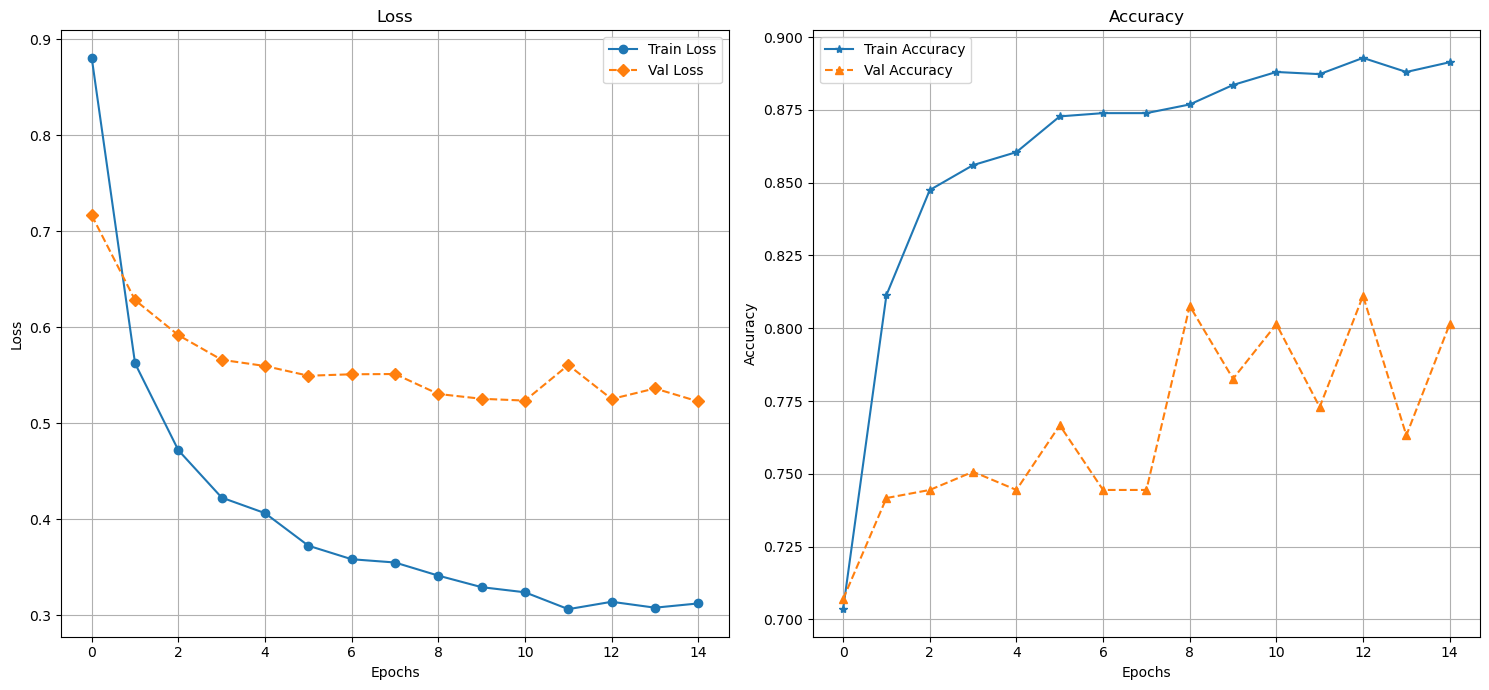

In [29]:
plot_loss_curves(results=results)

### Getting the Confusion Matrix

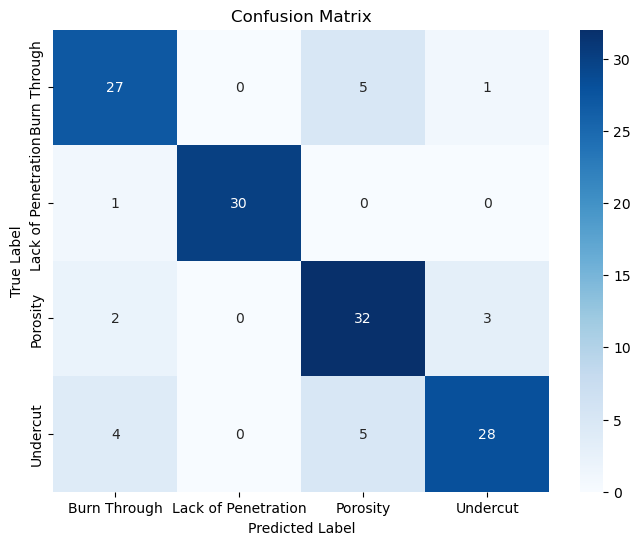

In [30]:
plot_confusion_matrix(model = effnetb0_model,
                     dataloader=effnetb0_testloader,
                     class_names=class_names,
                     device = device)

### 2.2 Fine Tuning Base EfficientNetB0 for 5 epochs

In [31]:
from pathlib import Path

checkpoint_path = Path('C:/Users/Sadat Iqbal/Desktop/Python Works/Torch_CUDA/Publication_Phase_2_models/EfficientNetB0_Augmented_data_15_epochs.pth')
checkpoint = torch.load(checkpoint_path,
                       map_location=device)

C:\Users\Sadat Iqbal\AppData\Local\Temp\ipykernel_22700\2814240016.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,


In [32]:
effnetb0_finetune = torchvision.models.efficientnet_b0(weights=None).to(device)
effnetb0_finetune.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=4)  # Match your initial training
).to(device)

#Loading model weights
effnetb0_finetune.load_state_dict(checkpoint['model_state_dict'])


#freezing all the feature extractor parameters
for name, param in effnetb0_finetune.features.named_parameters():
    param.requires_grad = False

for name, param in list(effnetb0_finetune.features.named_parameters())[-10:]:
    param.requires_grad = True

In [33]:
summary(effnetb0_finetune,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32

In [34]:
#setting up a loss_fn, optimizer and lr_scheduler (optional)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, effnetb0_finetune.parameters()),
    lr = 1e-4
)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

fine_tune_epochs = 5

start_time = timer()

finetune_results = train(model=effnetb0_finetune,
                        train_dataloader=effnetb0_train_loader_aug,
                        val_dataloader=effnetb0_val_loader,
                        optimizer=optimizer,
                        loss_fn=criterion,
                        epochs=fine_tune_epochs,
                        device=device,
                        writer=create_writer(experiment_name='Augmented_Data',
                                     model_name='EffnetB0',
                                     extra = f'finetuned_for_{fine_tune_epochs}_epochs')
                        )
end_time = timer()
print(f"Total time for fine-tuning: {end_time - start_time:.3f} seconds")

save_filepath = 'EfficientNetB0_Augmented_data_finetuned_5_epochs.pth'
save_model(model = effnetb0_finetune,
          optimizer=optimizer,
          epoch=fine_tune_epochs,
          initial_training_completed=True,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('Fine-tuned model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffnetB0\finetuned_for_5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.3066 and Train acuuracry: 0.8917 |
                  Validation loss: 0.5101 and Validation accuracy: 0.8014|
                  LR: 0.0001
Epoch: 2| Train loss: 0.2389 and Train acuuracry: 0.9211 |
                  Validation loss: 0.4625 and Validation accuracy: 0.8299|
                  LR: 0.0001
Epoch: 3| Train loss: 0.1879 and Train acuuracry: 0.9420 |
                  Validation loss: 0.4416 and Validation accuracy: 0.8299|
                  LR: 0.0001
Epoch: 4| Train loss: 0.1621 and Train acuuracry: 0.9535 |
                  Validation loss: 0.4194 and Validation accuracy: 0.8424|
                  LR: 0.0001
Epoch: 5| Train loss: 0.1540 and Train acuuracry: 0.9550 |
                  Validation loss: 0.4220 and Validation accuracy: 0.8299|
                  LR: 0.0001
Total time for fine-tuning: 171.690 seconds
[INFO] Saving checkpoint to: Publication_Phase_2_models\EfficientNetB0_Augmented_data_finetuned_5_epochs.pth
Fine-tuned model saved to desire

### loss curves

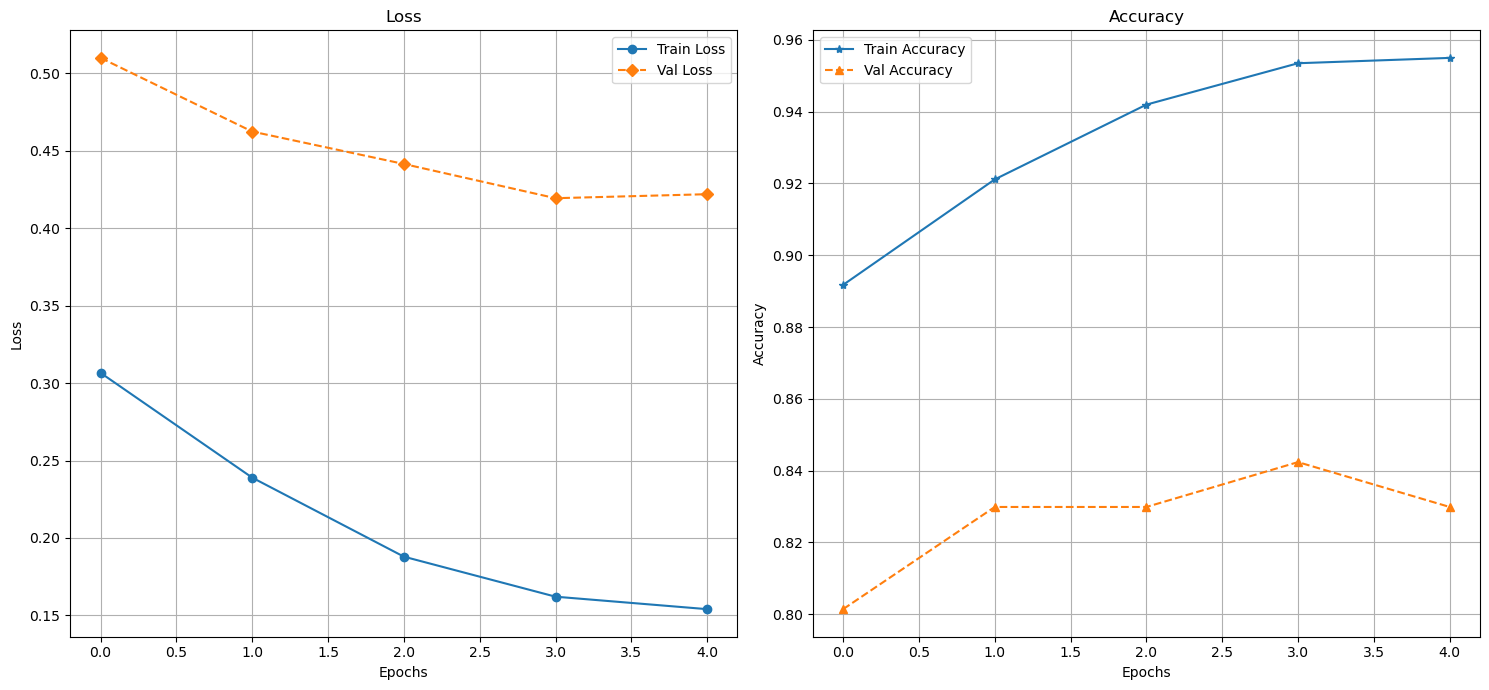

In [36]:
plot_loss_curves(results=finetune_results)

### Confusion Matrix

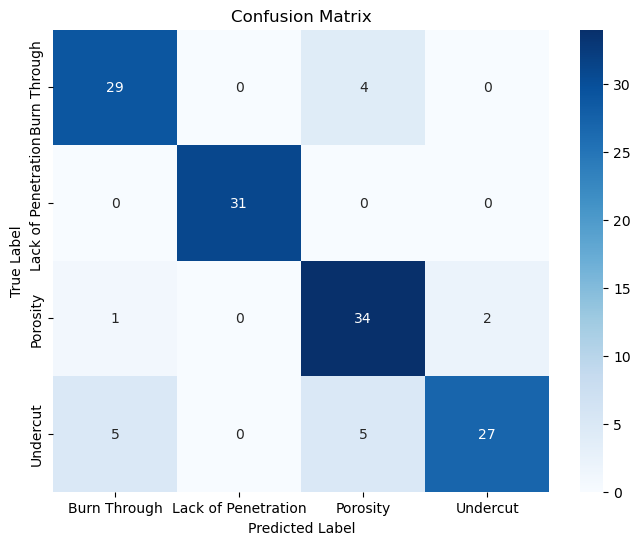

In [37]:
plot_confusion_matrix(model=effnetb0_finetune,
                     dataloader=effnetb0_testloader,
                     class_names=class_names,
                     device = device)

# 3. Effect of Attention Modules

In [38]:
from AttentionModules.CBAM import CBAM
from AttentionModules.SENet import SEModule

### 3.1 Integrating SENet

In [39]:
class effnetb0_with_senet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
        self.model = torchvision.models.efficientnet_b0(weights=self.weights)
        self.feature_extractor = self.model.features
        self.senet = SEModule(channels=1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=num_classes)
        )

    def forward(self,x):
        x = self.feature_extractor(x)
        x = self.senet(x)
        x = self.pool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)

        return x

In [40]:
effnetb0_se = effnetb0_with_senet(num_classes=num_classes).to(device)

summary(effnetb0_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
effnetb0_with_senet (effnetb0_with_senet)                    [32, 3, 224, 224]    [32, 4]              1,281,000            True
├─Sequential (feature_extractor)                             [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [41]:
for param in effnetb0_se.feature_extractor.parameters():
    param.requires_grad = False

for param in effnetb0_se.classifier.parameters():
    param.requires_grad = True

summary(effnetb0_se,
       input_size=(32,3,224,224),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
effnetb0_with_senet (effnetb0_with_senet)                    [32, 3, 224, 224]    [32, 4]              1,281,000            Partial
├─Sequential (feature_extractor)                             [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb0_se.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                           step_size=10,
                                           gamma=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 15

start_time = timer()

results_se = train(model = effnetb0_se,
                  train_dataloader=effnetb0_train_loader_aug,
                  val_dataloader=effnetb0_val_loader,
                  optimizer=optimizer,
                  loss_fn=criterion,
                  lr_scheduler=scheduler,
                  device=device,
                  epochs=n_epochs,
                  writer=create_writer(experiment_name='Augmented_Data',
                                      model_name = 'EffnetB0_with_SENet',
                                      extra=f'{n_epochs}_epochs')
                  )

end_time = timer()
print(f'Total training time with SENet: {end_time-start_time:.3f} seconds')

save_filepath = 'EfficientNetB0_with_SENet_Augmented_data_15_epochs.pth'
save_model(model=effnetb0_se,
          optimizer=optimizer,
          scheduler=scheduler,
          epoch=n_epochs,
          initial_training_completed=False,
          target_dir='Publication_Phase_2_models',
          model_name=save_filepath)

print('model saved to desired directory!!!'+'\n')
print('-'*50)

Created SummaryWriter saving to Publication_Phase_2_logs\2025-09-02\Augmented_Data\EffnetB0_with_SENet\15_epochs


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1| Train loss: 0.8938 and Train acuuracry: 0.7016 |
                  Validation loss: 0.7286 and Validation accuracy: 0.7479|
                  LR: 0.001
Epoch: 2| Train loss: 0.5246 and Train acuuracry: 0.8251 |
                  Validation loss: 0.6205 and Validation accuracy: 0.7542|
                  LR: 0.001
Epoch: 3| Train loss: 0.4211 and Train acuuracry: 0.8601 |
                  Validation loss: 0.5758 and Validation accuracy: 0.7889|
                  LR: 0.001
Epoch: 4| Train loss: 0.3586 and Train acuuracry: 0.8761 |
                  Validation loss: 0.5381 and Validation accuracy: 0.8236|
                  LR: 0.001
Epoch: 5| Train loss: 0.3251 and Train acuuracry: 0.8977 |
                  Validation loss: 0.5521 and Validation accuracy: 0.7764|
                  LR: 0.001
Epoch: 6| Train loss: 0.2696 and Train acuuracry: 0.9111 |
                  Validation loss: 0.5309 and Validation accuracy: 0.7826|
                  LR: 0.001
Epoch: 7| Train loss: 0.2383

### loss cruves

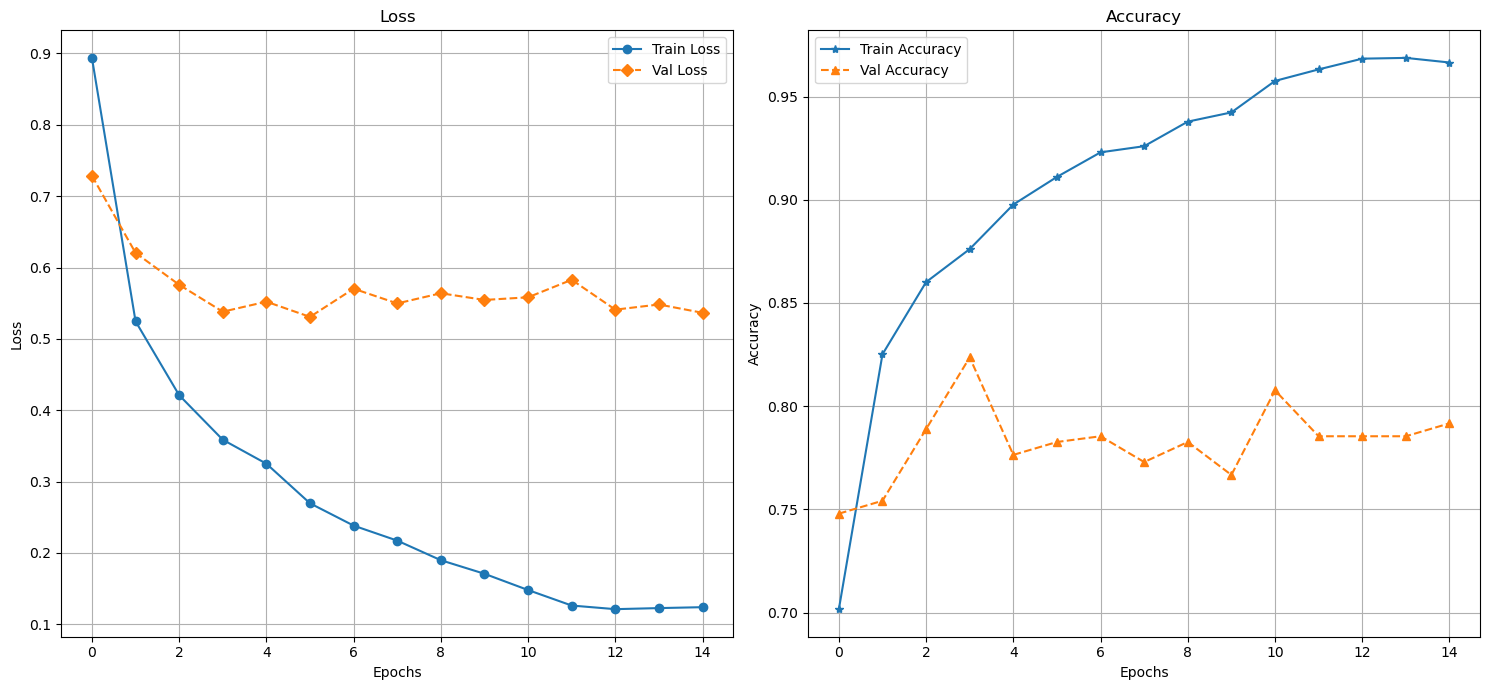

In [43]:
plot_loss_curves(results = results_se)

### Confusion Matrix

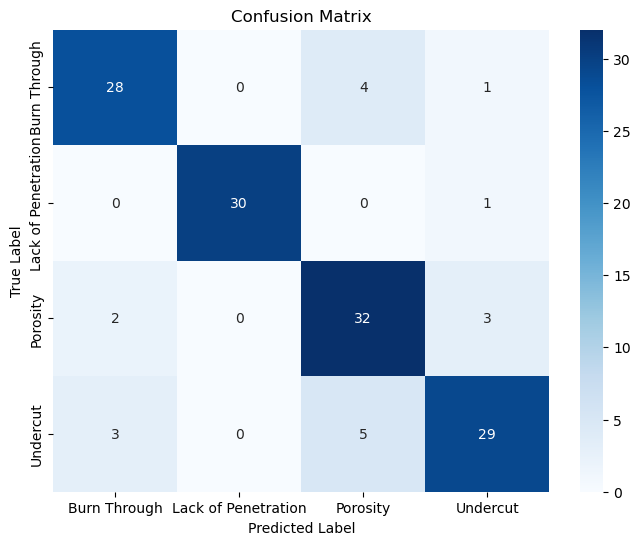

In [44]:
plot_confusion_matrix(model = effnetb0_se,
                     dataloader=effnetb0_testloader,
                     class_names=class_names,
                     device = device)